<a href="https://colab.research.google.com/github/YoheiFukuhara/keras-for-beginner/blob/master/Keras11_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなseq2seq
Seq2Seqで正弦(sin)関数から余弦(cos)関数への変換を実施 

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.python.keras.utils.vis_utils import plot_model

## データ作成
訓練用データを作成します。  
正弦(sin)関数の値をencoderへの入力、余弦(cos)関数の値を正解とします。  
decoderへの入力は、正解から一つ後の時刻にずらします。
これによりdecoderの出力が、次の入力に近づくように学習をします。  
このような、正解が入力となる手法を**教師強制**といいます。

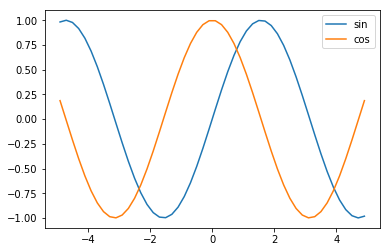

In [2]:
axis_x = np.linspace(-4.9, 4.9) #-4.9から4.9までの50要素の等差数列作成

sin_data = np.sin(axis_x)  # 正弦(sin)関数
cos_data = np.cos(axis_x)  # 余弦(cos)関数

plt.plot(axis_x, sin_data, label='sin')
plt.plot(axis_x, cos_data, label='cos')
plt.legend()
plt.show()

In [0]:
N_RNN = 10  # 1セットのデータ数
N_SAMPLE = len(axis_x)-N_RNN  # サンプル数(今回は50-10=40)
N_IN_OUT = 1 # 入力層・出力層のニューロン数
N_MID = 20  # 中間層のニューロン数
shape_ = (N_SAMPLE, N_RNN, )

x_encoder = np.zeros(shape_)  # encoderの入力
x_decoder = np.zeros(shape_)  # decoderの入力
y_decoder = np.zeros(shape_)  # decoderの正解

for i in range(N_SAMPLE):
    x_encoder[i] = sin_data[i:i+N_RNN] #正弦(sin)関数を10づつ入力
    x_decoder[i, 1:] = cos_data[i:i+N_RNN-1]  # 最初の値は0のままでひとつ後にずらす
    y_decoder[i] = cos_data[i:i+N_RNN]  # 正解は余弦(cos)関数の値をそのまま入れる

# サンプル数、時系列の数、入力層のニューロン数にreshape
x_encoder = x_encoder.reshape(shape_+(N_IN_OUT,))
x_decoder = x_decoder.reshape(shape_+(N_IN_OUT,))
y_decoder = y_decoder.reshape(shape_+(N_IN_OUT,))

## Seq2Seqの訓練モデル構築
KerasでLSTMを使ってSeq2Seqの訓練モデルを構築します。  

In [0]:
def train_model():
    # input
    encoder_input = Input(shape=(N_RNN, N_IN_OUT)) # encoderの入力層
    decoder_input = Input(shape=(N_RNN, N_IN_OUT)) # decoderの入力層

    # encoder
    # return_stateをTrueにすることで、状態（htとメモリセル）が得られる。return_sequnceは不要
    encoder_output, state_h, state_c = LSTM(N_MID, return_state=True)(encoder_input)  # encoder LSTMの最終出力、状態(ht)、状態(メモリセル)
    encoder_states = [state_h, state_c] # LSTM結果のencoder_stateをdecoderのLSTM中間状態に渡す

    # decoder
    decoder_lstm = LSTM(N_MID, return_sequences=True, return_state=True)  # return_stateをTrueにすることで、状態（htとメモリセル）が得られる。
    decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)  # encoderから得る状態を使用。状態(htとメモリセル)は不要
    decoder_dense = Dense(N_IN_OUT, activation='linear') # 予測で再利用のために全結合を定義
    decoder_output = decoder_dense(decoder_output)

    model = Model([encoder_input, decoder_input], decoder_output)  # 入力と出力を設定し、Modelクラスでモデルを作成
    model.compile(loss="mean_squared_error", optimizer="adam")
    model.summary()
        
    return model, encoder_input, encoder_states, decoder_lstm, decoder_dense

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20), (None,  1760        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 10, 20), (No 1760        input_2[0]

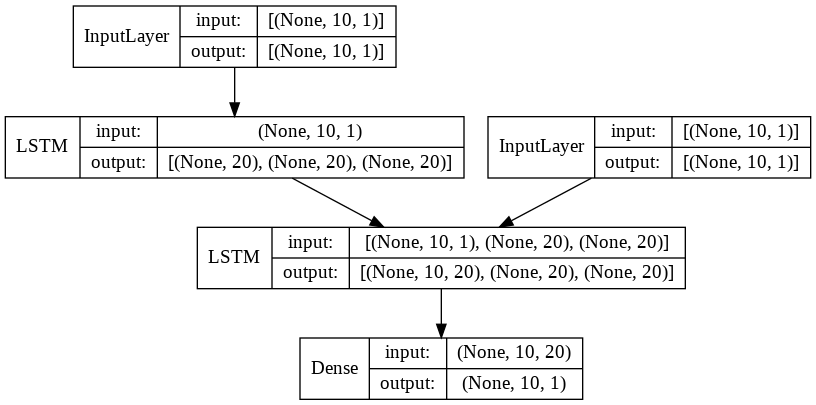

In [5]:
# 訓練モデル定義と出力
model, encoder_input, encoder_states, decoder_lstm, decoder_dense = train_model()
plot_model(model, show_shapes=True, show_layer_names=False)

## 訓練
構築したSeq2Seqのモデルを使って訓練を行います。

In [6]:
history = model.fit([x_encoder, x_decoder], y_decoder, batch_size=8, epochs=40)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
40/40 [==============================] - 1s 22ms/sample - loss: 0.6774
Epoch 2/40
40/40 [==============================] - 0s 1ms/sample - loss: 0.6270
Epoch 3/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.5807
Epoch 4/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.5400
Epoch 5/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.5023
Epoch 6/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.4645
Epoch 7/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.4308
Epoch 8/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.3988
Epoch 9/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.3741
Epoch 10/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.3464
Epoch 11/40
40/40 [==============================] - 0s 2ms/sample - loss: 0.3232
Epoch 12/40


## 学習の推移
誤差の推移を確認します。

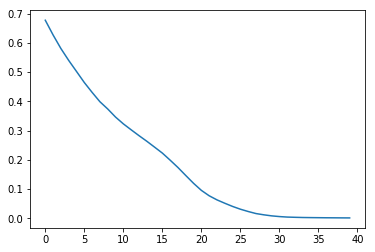

In [7]:
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

30エポックほどで誤差は収束しているようです。

## 予測用モデルの構築
学習済みのオブジェクトから、encoder、decoderのモデルを個別に構築します。    
encoderは入力を受け取って状態を返し、decoderは入力と状態を受け取って出力と状態を返すようにします。

In [0]:
def predict_model(encoder_input, encoder_states, decoder_lstm, decoder_dense):
    # encoderのモデルを構築
    encoder_model = Model(encoder_input, encoder_states)

    # decoderのモデルを構築
    decoder_input = Input(shape=(1, N_IN_OUT)) # (1, 1)

    # n_midは中間層のニューロン数(今回は20)
    # 状態(ht)と状態(メモリセル)の入力定義
    decoder_state_in = [Input(shape=(N_MID,)), Input(shape=(N_MID,))]

    decoder_output, decoder_state_h, decoder_state_c = \
        decoder_lstm(decoder_input, initial_state=decoder_state_in) # 既存の学習済みLSTM層を使用
    decoder_states = [decoder_state_h, decoder_state_c]

    decoder_output = decoder_dense(decoder_output) # 既存の学習済み全結合層を使用
    decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_states) # リストを+で結合

    return encoder_model, decoder_model

# 予測モデル定義
encoder_model, decoder_model = predict_model(encoder_input, encoder_states, decoder_lstm, decoder_dense)

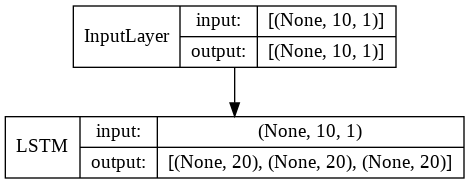

In [9]:
# 予測 encoderモデル出力
plot_model(encoder_model, show_shapes=True, show_layer_names=False)

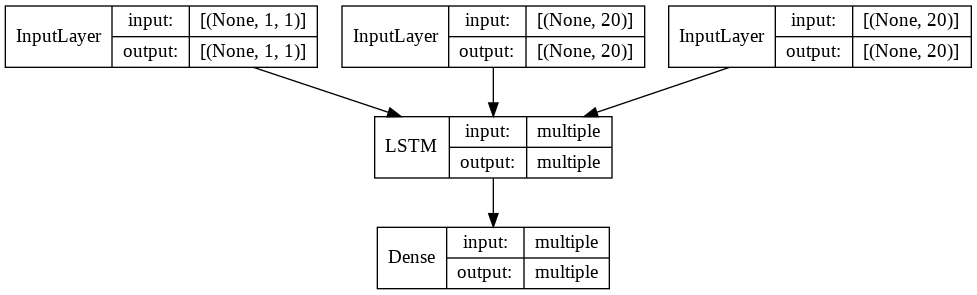

In [10]:
# 予測 decoderモデル出力
plot_model(decoder_model, show_shapes=True, show_layer_names=False)

## 変換用の関数
入力を出力に変換するための関数を定義

In [0]:
def predict(x_test):
    state_value = encoder_model.predict(x_test)  # encoderにデータを投げて状態(htとメモリセル)取得
    y_decoder = np.zeros((1, 1, 1)) # 出力の値
    predicted = [] # 変換結果
    
    for i in range(N_RNN):
        y, h, c = decoder_model.predict([y_decoder] + state_value)  # 前の出力と状態を渡す
        y = y[0][0][0]
        predicted.append(y)
        y_decoder[0][0][0] = y  # 次に渡す値
        state_value = [h, c] # 次に渡す状態

    return predicted

## 変換を実行
正弦(sin)関数の曲線を、余弦(cos)関数の曲線に変換します。

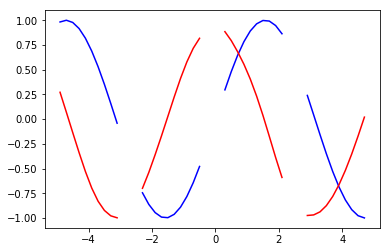

In [14]:
demo_idices = [0, 13, 26, 39]  # デモデータのインデックス
for i in demo_idices:
    x_test = x_encoder[i:i+1] # 入力を一部取り出す(x_encoderは40.10,1の3次元配列で、1次元目がdemo_indicesの配列を10個取り出している)
    y_test = predict(x_test)

    plt.plot(axis_x[i:i+N_RNN], x_test.reshape(-1), color="b") # 変換前（青）
    plt.plot(axis_x[i:i+N_RNN], y_test, color="r") # 変換後（赤）

plt.show()    